# Import Libraries

In [1]:
# Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# To handle data wrangling
from sklearn.preprocessing import FunctionTransformer 
from feature_engine.encoding import CountFrequencyEncoder, OneHotEncoder
from feature_engine.imputation import AddMissingIndicator, MeanMedianImputer
from feature_engine.selection import DropFeatures
from sklearn.pipeline import Pipeline

# To interpret results
from lime.lime_tabular import LimeTabularExplainer

# To display explanations with white background
from IPython.core.display import display, HTML

# To import best model
import pickle

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score


pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Load Data

In [2]:
dtypes = {'Store': int,
          'DayOfWeek':int,
          'Date':str,
          'Sales':int,
          'Customers':int,
          'Open':int,
          'Promo':int,
          'StateHoliday':str,
          'SchoolHoliday':int,
}

In [3]:
# Loading raw data
raw_data = pd.read_csv('train.csv', dtype=dtypes, index_col='Date', parse_dates = True)

# Dropping unnecessary rows/cols
data = raw_data[(raw_data.Sales > 0) & (raw_data.Open > 0)]
data = data.drop(['Open', 'Customers'], axis=1)

In [4]:
# Joining "stores" data
stores = pd.read_csv('stores_data.csv', index_col='Store')
data = data.join(stores, on = 'Store')

In [5]:
# Splitting between train and test set to forecast the last 6 weeks for the 1115 stores
split_index = 6*7*1115

train = data[split_index:]
test = data[:split_index] 

In [6]:
X_train = train.drop(['Sales'], axis = 1)
y_train = train.Sales

In [7]:
X_val = test.drop(['Sales'], axis = 1)
y_val = test.Sales

In [8]:
train_date = X_train.index
test_date = X_val.index

# Configuration

## Target

In [9]:
y_train = np.log(y_train)
y_val = np.log(y_val)

## Features

In [10]:
def extract_dates(df):
    df = df.copy()
    
    df['Year'] = df.index.year
    df['Month'] = df.index.month
    df['Week'] = df.index.isocalendar().week
    df['Day'] = df.index.day
    
    return df

In [11]:
HOLIDAY_MAPPING = {'0':0, 'a':1, 'b':1, 'c':1}

def map_holidays(df):
    df = df.copy()
    df.StateHoliday = df.StateHoliday.replace(HOLIDAY_MAPPING)
    
    return df

In [12]:
with open("dict_day_cust.pkl", "rb") as fp:   
    dict_day_cust = pickle.load(fp)     
    
def daily_customers(df):
    df['AvgWeaklyCusts'] = df.Week.replace(dict_day_cust)
    
    return df

# Pipeline

In [13]:
pipe = Pipeline([
#   ==== ADDING DATE FEATURES ==== 
     ('date_features', FunctionTransformer(extract_dates)),

#   ==== MAPPING ==== 
     ('holidays', FunctionTransformer(map_holidays)),    
    
    
#   ==== ADDING DAILY CUSTOMERS ==== 
     ('daily_customers', FunctionTransformer(daily_customers)),    
        

#    ==== DROP FEATURES ====
    ('drop_stores', DropFeatures(features_to_drop = ['Store']))
        
    
])

In [14]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('date_features',
                 FunctionTransformer(func=<function extract_dates at 0x000002159EACCA60>)),
                ('holidays',
                 FunctionTransformer(func=<function map_holidays at 0x000002159EAD83A0>)),
                ('daily_customers',
                 FunctionTransformer(func=<function daily_customers at 0x000002159EAD85E0>)),
                ('drop_stores', DropFeatures(features_to_drop=['Store']))])

In [15]:
## Transform datasets & get feature names
X_train = pipe.transform(X_train)
feat_names = X_train.columns

X_val = pipe.transform(X_val)

In [16]:
X_train.head(3)

,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,...,"PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Feb,May,Aug,Nov","PromoInterval_Mar,Jun,Sept,Dec",StateGDP,StateDensity,Year,Month,Week,Day,AvgWeaklyCusts
Date,,,,,,,,,,,,,,,,,,,,,
2015-06-13,6,0,0,0,17,7.265,8,2010,0,0,...,0,0,0,34885,301,2015,6,24,13,6.453
2015-06-13,6,0,0,0,602,6.768,3,2006,0,0,...,0,0,0,28806,3890,2015,6,24,13,6.453
2015-06-13,6,0,0,0,602,9.043,11,1994,0,0,...,0,0,0,34885,301,2015,6,24,13,6.453


# Model Performance

In [17]:
%%time
with open("RFRegressor.pkl", "rb") as fp:  
    model = pickle.load(fp)

model.fit(X_train, y_train)

Wall time: 44.5 s


RandomForestRegressor(max_depth=48, max_features=24, max_samples=0.8,
                      min_samples_leaf=2, min_samples_split=3, n_estimators=50,
                      n_jobs=-1, random_state=42)

In [18]:
y_pred = model.predict(X_val)

In [19]:
# Transform to original scale
y_pred = np.exp(y_pred)
y_val = np.exp(y_val)

In [20]:
# Define Root Mean Square Percentage Error (RMSPE)
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean((y_pred/y_true-1) ** 2))

In [21]:
# Scale back predictions as suggested https://www.kaggle.com/competitions/rossmann-store-sales/discussion/17601
y_pred_scaled = y_pred * 0.985

In [22]:
error = rmspe(y_val, y_pred)
print('RMSPE for normal pred: {:.4f}'.format(error))

error = rmspe(y_val, y_pred_scaled)
print('RMSPE for scaled pred: {:.4f}'.format(error))

RMSPE for normal pred: 0.1328
RMSPE for scaled pred: 0.1292


In [23]:
# Getting metrics
rmse = mean_squared_error(y_val, y_pred, squared=False)
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

# determine rmse, mae, and r2
print('val- mean sales:', round(y_val.mean()))
print('val- std sales:', round(y_val.std()))

print('\nval- rmse:', round(rmse))
print('val- mae:',  round(mae))

print('\nval- r2:', round(r2, 3))

val- mean sales: 7120
val- std sales: 3091

val- rmse: 960
val- mae: 646

val- r2: 0.903


In [24]:
# Getting metrics
rmse = mean_squared_error(y_val, y_pred_scaled, squared=False)
mae = mean_absolute_error(y_val, y_pred_scaled)
r2 = r2_score(y_val, y_pred_scaled)

print('\nval- rmse (on scaled sales):', round(rmse))
print('val- mae (on scaled sales):',  round(mae))

print('\nval- r2 (on scaled sales):', round(r2, 3))


val- rmse (on scaled sales): 964
val- mae (on scaled sales): 648

val- r2 (on scaled sales): 0.903


In [25]:
y_comp = pd.DataFrame(np.stack((y_val, y_pred), axis=1), 
                 columns=['y_val', 'y_pred'], 
                 index=y_val.index)
y_comp.head()

,y_val,y_pred
Date,,
2015-07-31,5263.000,5886.853
2015-07-31,6064.000,6094.160
2015-07-31,8314.000,9635.507
2015-07-31,13995.000,12758.823
2015-07-31,4822.000,6142.490


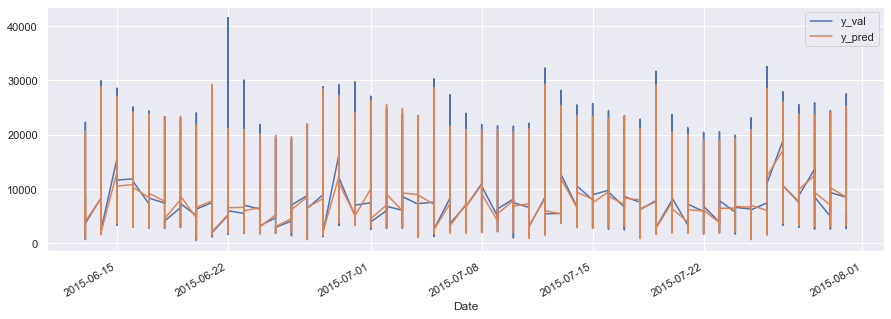

In [26]:
y_comp.plot(figsize = (15,5))
plt.show()

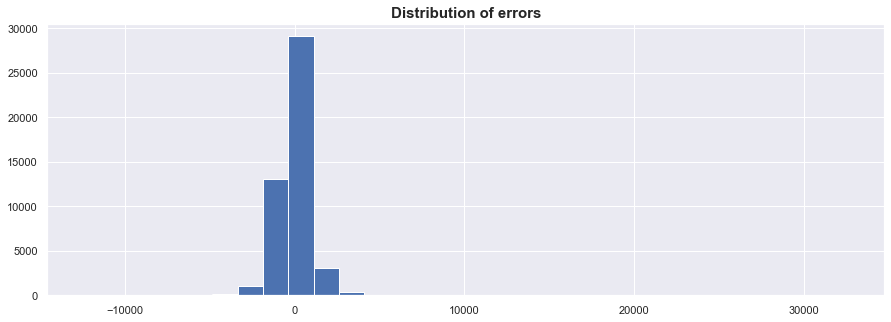

In [27]:
plt.figure(figsize = (15,5))
errors = y_val - y_pred
errors.hist(bins = 30)
plt.title('Distribution of errors', weight = 'bold', size = 15)
plt.show()

# Interpretations

### Feature Importances

In [28]:
df_model = pd.DataFrame(
{
    'features':feat_names,
    'importance': model.feature_importances_
})
df_model = df_model.sort_values(by = ['importance'], ascending = False)

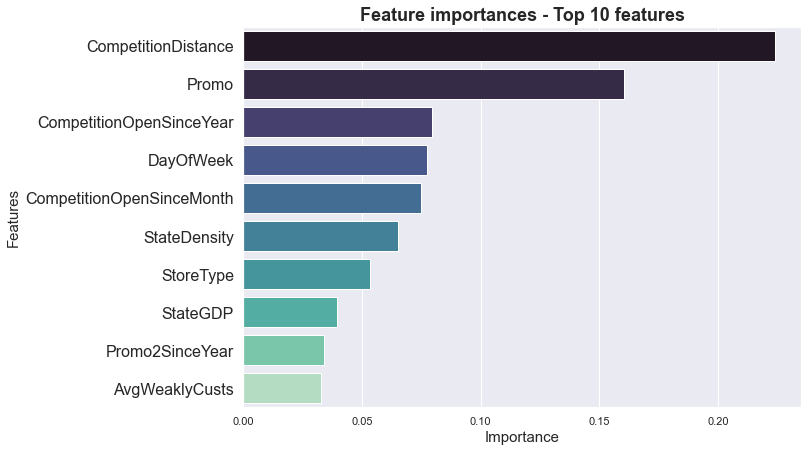

In [29]:
plt.figure(figsize = (10,7))

sns.barplot(y=df_model.features[:10], x=df_model.importance[:10], palette="mako" )

plt.title('Feature importances - Top 10 features', weight = 'bold', size = 18)
plt.yticks(fontsize = 16)
plt.ylabel('Features', fontsize = 15)
plt.xlabel('Importance', fontsize = 15)
plt.show()

# LIME

In [30]:
explainer = LimeTabularExplainer(X_val.values, 
                                 feature_names=feat_names, 
                                 verbose=True, mode='regression')

### Low Sales interpretation

In [31]:
i = 0
exp = explainer.explain_instance(data_row = X_val.values[i],
                                 labels=feat_names, 
                                 predict_fn=model.predict, 
                                 num_features=7)
print('\nLog-Real output:', np.log(y_val[i]))
print('Real output:', y_val[i])

Intercept 8.663174133582858
Prediction_local [8.89129863]
Right: 8.680476825080207

Log-Real output: 8.56845648535378
Real output: 5263.000000000004


C:\Users\pauli\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [32]:
# source code: https://github.com/marcotcr/lime/issues/443
exp.save_to_file('ex.html')

display(HTML('<iframe src=ex.html width=900 style="background:white;" height=350></iframe>'))

D:\ProgramData\Anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


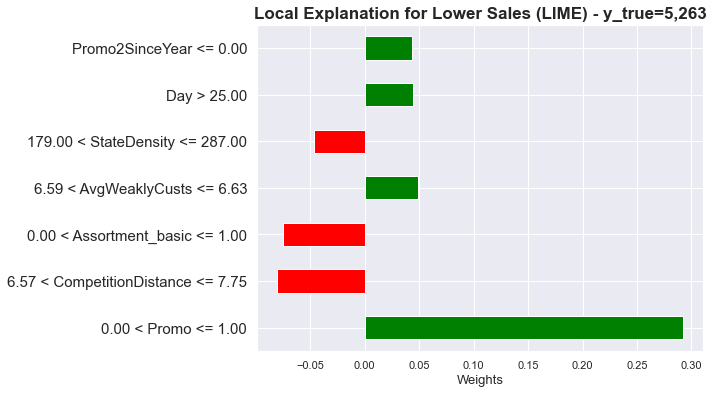

In [33]:
# Getting data
df_pred = pd.DataFrame(exp.as_list()).T
df_pred.columns = df_pred.iloc[0]
df_pred = df_pred.iloc[1]

# Getting colors
colors = ['green' if weight > 0 else 'red' for weight in df_pred.values ]

# Plotting
plt.figure(figsize=(8,6))
df_pred.plot.barh(color = colors)
plt.title('Local Explanation for Lower Sales (LIME) - y_true=5,263', weight = 'bold', size = 17)
plt.xlabel('Weights', size = 13)
plt.ylabel('')
plt.yticks(size=15)
plt.show()

### High Sales Interpretation

In [34]:
for i, (y, yhat) in enumerate(zip(y_val, y_pred)):
    # Getting a high sales value
    if y > 30000:
        # Getting an obs. with a relatively good prediction
        if y-yhat < 3000:
            print(i)
            break

12279


In [35]:
i = 12279
exp = explainer.explain_instance(data_row = X_val.values[i],
                                 labels=feat_names, 
                                 predict_fn=model.predict, 
                                 num_features=7)
print('\nLog-Real output:', np.log(y_val[i]))
print('Real output:', y_val[i])

Intercept 8.93907052614398
Prediction_local [8.70604227]
Right: 10.280060700913216

Log-Real output: 10.36296724895053
Real output: 31665.0


C:\Users\pauli\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [36]:
# source code: https://github.com/marcotcr/lime/issues/443
exp.save_to_file('ex.html')

display(HTML('<iframe src=ex.html width=900 style="background:white;" height=350></iframe>'))

D:\ProgramData\Anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


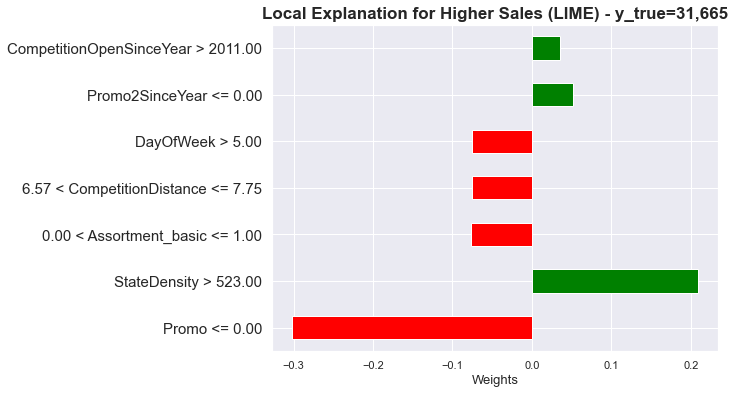

In [37]:
# Getting data
df_pred = pd.DataFrame(exp.as_list()).T
df_pred.columns = df_pred.iloc[0]
df_pred = df_pred.iloc[1]

# Getting colors
colors = ['green' if weight > 0 else 'red' for weight in df_pred.values ]

# Plotting
plt.figure(figsize=(8,6))
df_pred.plot.barh(color = colors)
plt.title('Local Explanation for Higher Sales (LIME) - y_true=31,665', weight = 'bold', size = 17)
plt.xlabel('Weights', size = 13)
plt.ylabel('')
plt.yticks(size=15)
plt.show()